# Cox model execution - 1st article
In this notebook, we test the Cox model for the data from the following article : https://doi.org/10.1158/1078-0432.CCR-20-1163.

## Notebook plan :
1. Reading
2. Feature selection
3. Predict low & high risk
4. Estimate survival curves for low & high risk

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from models.CoxModel import CoxModel
from utils.featureSelection import featureSelection
from utils.preProcessing import preProcessing

In [2]:
coxmodel = CoxModel()
feature_selector = featureSelection()
preprocessor = preProcessing()

## 1. Reading

In [3]:
df = pd.read_excel('data/table-s1-sigmut.xlsx')

# Delete non naive patients
df = preprocessor.filter_column(df, "Cohort", "Naive")

# Delete NaN values
df = preprocessor.delete_nan_values(df)
df

,Anonymous ID,EGA ID,Tumour type,Sex,Line of therapy,Immunotherapy regimen,Cohort,Reason for discontinuation,Best response,Age at advanced disease diagnosis,...,SBS6,SBS7a,SBS7b,SBS7c,SBS13,SBS26,SBS44,Tumour type.1,Exome mut per mb.1,Genome mut per mb.1
0,23701,EGAD00001002576,BRCA,F,7,"GEMCITABINE, VINORELBINE, PEMBROLIZUMAB (ARIZONA)",Naive,Progression/death,Progressive disease,30,...,0.000000,0.000000,0.000000,0.058643,0.219746,0.000000,0.000000,BRCA,5.617878,7.0476
1,25980,EGAD00001002997,BRCA,F,5,Pembrolizumab,Naive,Progression,Partial response,59,...,0.000000,0.000000,0.000000,0.068387,0.080349,0.000000,0.000000,BRCA,6.853812,9.3941
2,30221,EGAD00001003607,BRCA,F,1,Pembrolizumab,Naive,Progression,Progressive disease,53,...,0.055076,0.000000,0.000000,0.046292,0.109279,0.000000,0.000000,BRCA,6.853812,7.3266
3,31031,EGAD00001003720,BRCA,F,4,"TRASTUZUMAB, DURVALUMAB",Naive,Progression,Progressive disease,49,...,0.000000,0.000000,0.000000,0.049116,0.102175,0.000000,0.000000,BRCA,7.134706,8.3420
4,33532,EGAD00001004623,BRCA,F,6,"NIVOLUMAB (P1T986205),BMS-986205 (P1T986205)/I...",Naive,Progression,Stable disease,68,...,0.081547,0.000000,0.000000,0.054670,0.157417,0.068070,0.000000,BRCA,5.084180,5.9052
5,37970,EGAD00001004706,CHOL,M,2,"Tremelimumab, Durvalumab",Naive,Progression,Progressive disease,59,...,0.089383,0.000000,0.000000,0.048926,0.000000,0.000000,0.000000,CHOL,1.825810,2.5119
6,25419,EGAD00001002611,COLO,M,2,Atezolizumab,Naive,Progression,Progressive disease,48,...,0.239516,0.000000,0.000000,0.059283,0.034684,0.076539,0.000000,COLO,2.724671,4.3225
7,25589,EGAD00001002628,COLO,F,4,Nivolumab,Naive,Progression,Physician assessed PR,55,...,0.000000,0.000000,0.000000,0.000000,0.369304,0.000000,0.000000,COLO,16.348026,16.0194
8,25604,EGAD00001002632,GCT,M,5,Atezolizumab,Naive,Progression,Stable disease,26,...,0.052485,0.000000,0.087626,0.062000,0.036009,0.000000,0.000000,GCT,3.202191,5.2737
9,32395,EGAD00001003734,HNSC,M,1,Pembrolizumab,Naive,Death,Not evaluable,71,...,0.000000,0.509550,0.490450,0.000000,0.000000,0.000000,0.000000,HNSC,62.948328,96.0990


## 2. Feature selection

In [4]:
# Select features we want to study
studied_features = ["Age at advanced disease diagnosis","CD8+ T cell score","Exome mut per mb","Genome mut per mb","CD274 expression","M1M2 expression","SBS2","SBS4","SBS18","SBS5","SBS6","SBS7a","SBS7b","SBS7c","SBS13","SBS26","SBS44"]
df_feature_selection = df.loc[:,studied_features]

### a. Correlation

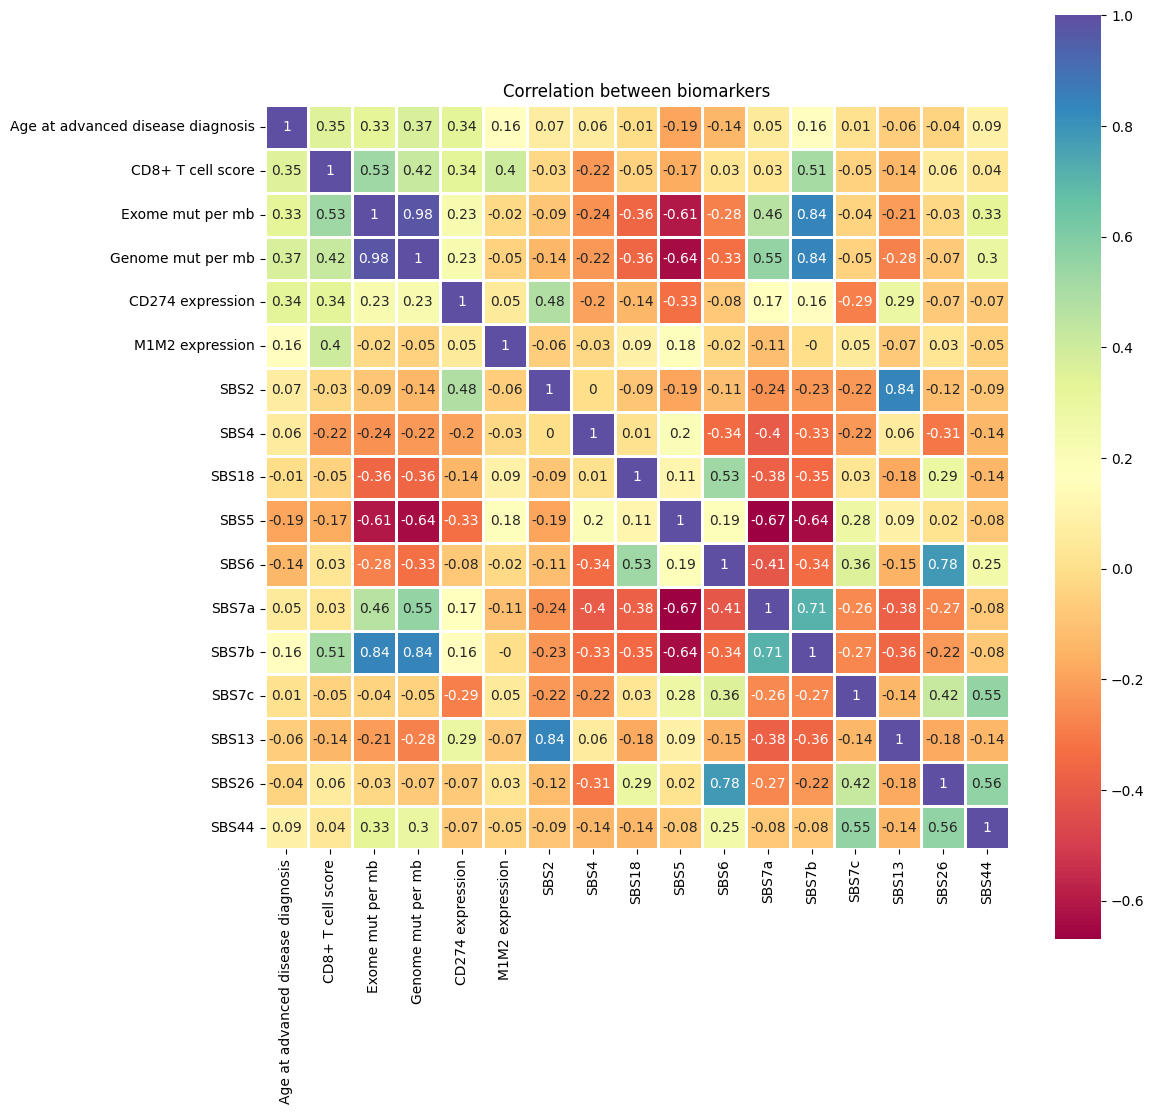

In [5]:
pearson_correlation = feature_selector.correlation(df_feature_selection, True)

### b. Feature importance

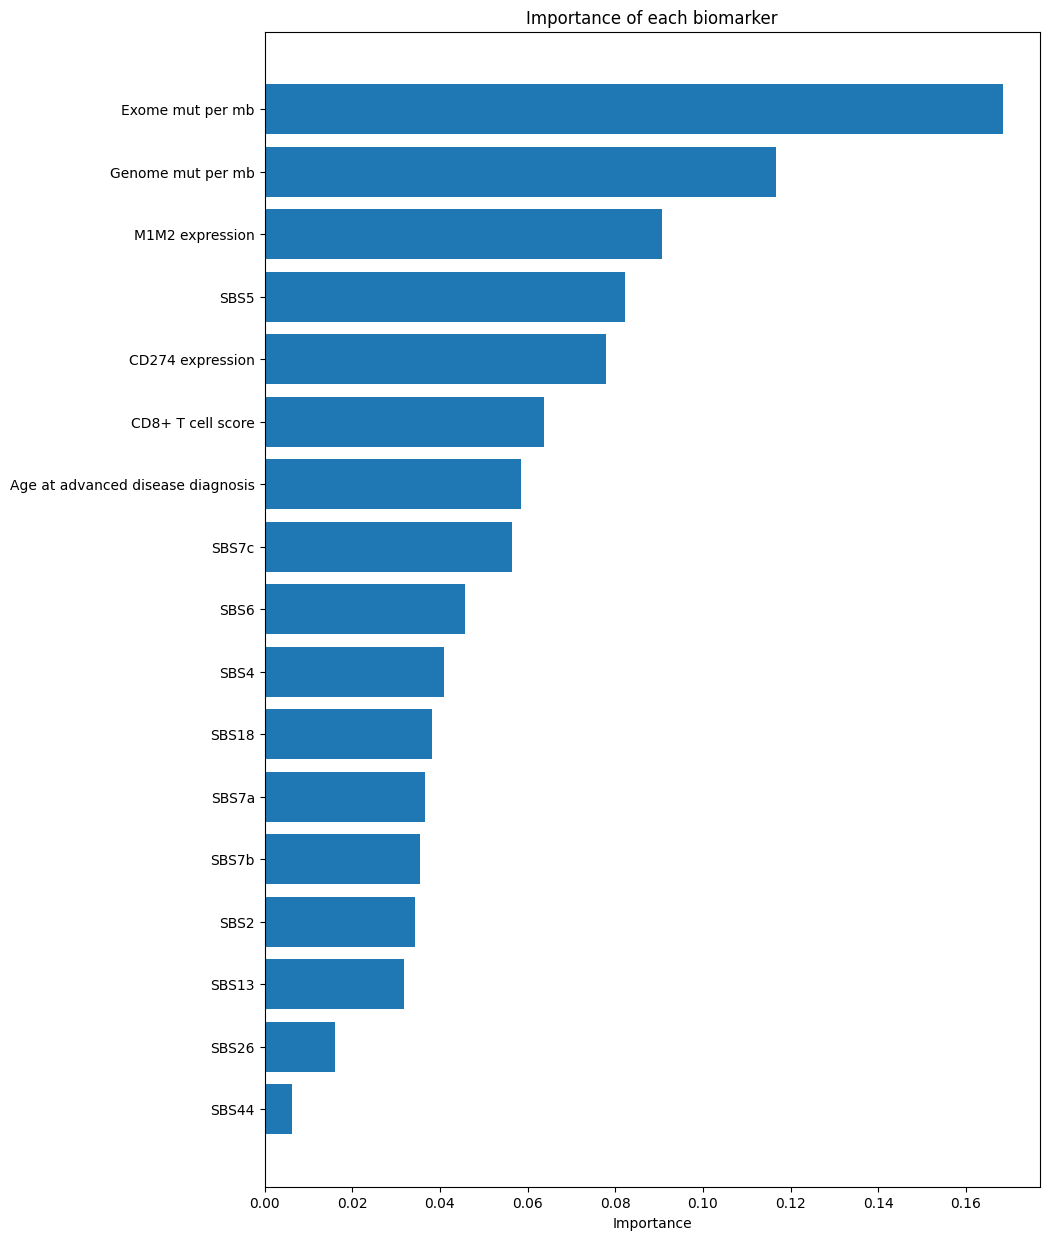

In [6]:
y_response = df["Clinical benefit"].to_numpy()

feat_importance = feature_selector.feature_importance(df_feature_selection, y_response, True)

### c. Conclusions
- We can see the SBS44, SBS26, SBS2 and SBS18 signatures are not important --> drop SBS44, SBS6, SBS2, SBS18
- SBS7a is not really important, and it is pretty correlated with SBS5 (-0.67) which is important --> drop SBS7a

We can keep the rest.

## 3. Predict low & high risk
With the ```CoxModel``` class implementing a Cox Regression, we can determine the risk class for each sample : high (class 1) or low (class 0). Because we have few data, we use a **leave one out cross validation**, which consists in fitting the model with all the dataset except 1 sample, then we predict the risk class for the test sample.

In [7]:
selected_columns = ["Age at advanced disease diagnosis","CD8+ T cell score","Exome mut per mb","Genome mut per mb","CD274 expression","M1M2 expression","SBS4","SBS5","SBS6","SBS7b","SBS7c","SBS13"]
X = df.loc[:,selected_columns].to_numpy()
y_ttp = np.array(list((df[['Progression_1','Time to progression (days)']].itertuples(index=False, name=None))),dtype=[('Progression_1', '?'), ('Time to progression (days)', '<f8')])
y_os = np.array(list((df[['Alive_0','Overall survival (days)']].itertuples(index=False, name=None))),dtype=[('Alive_0', '?'), ('Overall survival (days)', '<f8')])

### a. Normalization

In [8]:
X = preprocessor.normalize_data(X)

### b. Find risk classes

In [9]:
# Finding the risk classes - TTP
risk_classes_ttp, risk_scores_ttp = coxmodel.leave_one_out_cross_validation(X,y_ttp)
print("TTP :")
print(f"n_samples high risk : {np.where(risk_classes_ttp==1)[0].shape[0]}")
print(f"n_samples low risk : {np.where(risk_classes_ttp==0)[0].shape[0]}")

# Finding the risk classes - OS
print("\n OS :")
risk_classes_os, risk_scores_os = coxmodel.leave_one_out_cross_validation(X,y_os)
print(f"n_samples high risk : {np.where(risk_classes_os==1)[0].shape[0]}")
print(f"n_samples low risk : {np.where(risk_classes_os==0)[0].shape[0]}")

TTP :
n_samples high risk : 18
n_samples low risk : 16

 OS :
n_samples high risk : 18
n_samples low risk : 16


### c. Compute concordance index
In this context, the concordance index measures the proportion of patients comparable pairs in which the risk score and the surviving time are concordant.

In [10]:
# TTP : 
status_ttp, time_ttp = df['Progression_1'].to_numpy().astype(bool), df['Time to progression (days)'].to_numpy()
c_index_ttp = coxmodel.get_c_index(status_ttp, time_ttp, risk_scores_ttp)
print(f"C index (TTP) : {c_index_ttp}")

# OS :
status_os, time_os = df['Alive_0'].to_numpy().astype(bool), df['Overall survival (days)'].to_numpy()
c_index_os = coxmodel.get_c_index(status_os, time_os, risk_scores_os)
print(f"C index (OS) : {c_index_os}")

C index (TTP) : 0.52
C index (OS) : 0.44


### d. Compute p value of the log rank test
The log rank test compares 2 survival curves. If the p value is low (under 5%), the 2 curves are different. Otherwise, the 2 curves are pretty similar. We make this test for the low risk (class 0) and high risk curves (class 1).

In [11]:
# TTP :
p_value_ttp = coxmodel.log_rank_test(status_ttp.astype(int), time_ttp, risk_classes_ttp)
print(f"p value (TTP) : {p_value_ttp}")

# OS :
p_value_os = coxmodel.log_rank_test(status_os.astype(int), time_os, risk_classes_os)
print(f"p value (OS) : {p_value_os}")

p value (TTP) : 0.38
p value (OS) : 0.71


## 4. Vizualize survival curves for each class

In [12]:
# TTP :
print("TTP : ")
# Low risk class
status_low_ttp, time_low_ttp = status_ttp[np.where(risk_classes_ttp==0)], time_ttp[np.where(risk_classes_ttp==0)]
time_axis_low_ttp, prob_axis_low_ttp = coxmodel.kaplan_meier_estimation(status_low_ttp, time_low_ttp)
# High risk class
status_high_ttp, time_high_ttp = status_ttp[np.where(risk_classes_ttp==1)], time_ttp[np.where(risk_classes_ttp==1)]
time_axis_high_ttp, prob_axis_high_ttp = coxmodel.kaplan_meier_estimation(status_high_ttp, time_high_ttp)
print(f"n_samples low risk : {status_low_ttp.shape[0]}")
print(f"n_samples high risk : {status_high_ttp.shape[0]}")

# OS :
print("\n OS : ")
# Low risk class
status_low_os, time_low_os = status_os[np.where(risk_classes_os==0)], time_os[np.where(risk_classes_os==0)]
time_axis_low_os, prob_axis_low_os = coxmodel.kaplan_meier_estimation(status_low_os, time_low_os)
# High risk class
status_high_os, time_high_os = status_os[np.where(risk_classes_os==1)], time_os[np.where(risk_classes_os==1)]
time_axis_high_os, prob_axis_high_os = coxmodel.kaplan_meier_estimation(status_high_os, time_high_os)
print(f"n_samples low risk : {status_low_os.shape[0]}")
print(f"n_samples high risk : {status_high_os.shape[0]}")

TTP : 
n_samples low risk : 16
n_samples high risk : 18

 OS : 
n_samples low risk : 16
n_samples high risk : 18


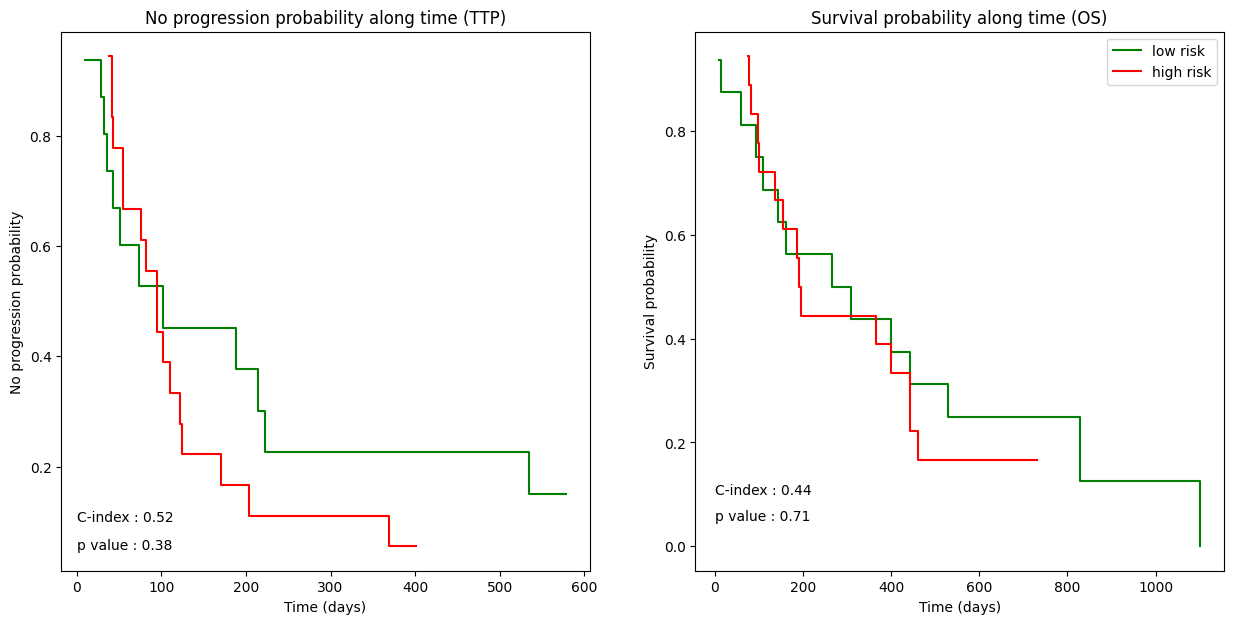

In [13]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
ax[0].step(time_axis_low_ttp, prob_axis_low_ttp, where='post',color='green',label='low risk')
ax[0].step(time_axis_high_ttp, prob_axis_high_ttp, where='post',color='red',label='high risk')
ax[0].set_xlabel('Time (days)')
ax[0].set_ylabel('No progression probability')
ax[0].set_title('No progression probability along time (TTP)')
ax[0].text(0,0.1,f'C-index : {c_index_ttp}')
ax[0].text(0,0.05,f'p value : {p_value_ttp}')

ax[1].step(time_axis_low_os, prob_axis_low_os, where='post',color='green',label='low risk')
ax[1].step(time_axis_high_os, prob_axis_high_os, where='post',color='red',label='high risk')
ax[1].set_xlabel('Time (days)')
ax[1].set_ylabel('Survival probability')
ax[1].set_title('Survival probability along time (OS)')
ax[1].text(0,0.1,f'C-index : {c_index_os}')
ax[1].text(0,0.05,f'p value : {p_value_os}')

plt.legend()
plt.savefig('km-survival-curve.png')